In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt

In [2]:
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p =  kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 10000 / koff
k_beta = koff 

p_scaled = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol


    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)

    steady = np.maximum(sol.x,[0,0])
    steady = sol.x

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p):

    # Parameters
    kdegR, ktrans, kdegP, mu_max_opto, mu_max_blind, Ks, Y, K_Rep = p

    x_guess = x
    global setpoint
    # if setpoint is None:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess)
    # else:
    #     out = setpoint
    # if ier != 1:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess=None)

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA, Rep, Enz_opto, Enz_blind, S, Xopto, Xblind = x
    mRNA_blind = 1

    

    mu_xopto = mu_max_opto * Enz_opto * S / (Ks + S)
    mu_xblind = mu_max_blind * Enz_blind * S / (Ks + S)

    dmRNAdt = (setpoint[1] - mRNA) / tau_mRNA

    ktrans_scaled = ktrans  * ((mu_max_opto + kdegP) / ktrans)

    # Enz_opto = Enz_opto / ((mu_max_opto + kdegP) / ktrans)
    dRepdt = ktrans_scaled * mRNA * S / (Ks + S) - (kdegP + mu_xopto) * Enz_opto
    dEnz_optodt = ktrans_scaled * (K_Rep / (K_Rep + Rep)) * S / (Ks + S) - (kdegP + mu_xopto) * Enz_opto
    # dEnz_optodt = dEnz_optodt * ((mu_max_opto + kdegP) / ktrans)

    # Enz_blind = Enz_blind / ((mu_max_blind + kdegP) / ktrans)
    dEnz_blind_optodt = ktrans * mRNA_blind * S / (Ks + S) - (kdegP + mu_xblind) * Enz_blind
    # dEnz_blind_optodt = dEnz_blind_optodt * ((mu_max_blind + kdegP) / ktrans)


    dSdt = - (mu_xopto / Y) * Xopto - (mu_xblind / Y) * Xblind
    dX_optodt = mu_xopto * Xopto
    dX_blind_optodt = mu_xblind * Xblind



    return [dmRNAdt, dRepdt, dEnz_optodt, dEnz_blind_optodt, dSdt, dX_optodt, dX_blind_optodt]


In [3]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.00

mu_max_opto = 2/200
mu_max_blind = mu_max_opto/1.2

mu_max = mu_max_opto
Ks = 1
Y = 0.5

In [4]:
from tqdm import tqdm

u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,100))))

# u_arr = np.flip(10 ** np.linspace(-1,0,100))
Enz_arr = np.zeros(u_arr.size)

setpoint = None
for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
    # print(u)
    period = 100 / 60
    Imax = 1
    setpoint = steady_mRNA_solve(u, period, Imax, x_guess=setpoint)
    # print(setpoint)
    mRNAss = setpoint[1]
    # if ier != 1:
    #     print('Failed at u=' + str(u))
    #     print(mesg)
    #     continue


    # Enz_opto = Enz_opto / ((mu_max_opto + kdegP) / ktrans)
    # dEnz_optodt = ktrans * mRNA * S / (Ks + S) - (kdegP + mu_xopto) * Enz_opto
    # dEnz_optodt = dEnz_optodt * ((mu_max_opto + kdegP) / ktrans)
    ktrans_scaled = ktrans  * ((mu_max_opto + kdegP) / ktrans)
    ss_Enz = - (1 / (2 * mu_max)) * (kdegP - np.sqrt(4 * mRNAss * mu_max * ktrans_scaled + kdegP ** 2))
    #ss_Enz = ss_Enz * ((mu_max_opto + kdegP) / ktrans)
    # print(ss_Enz)
    Enz_arr[i] = ss_Enz


100%|██████████| 101/101 [03:27<00:00,  2.05s/it]


In [5]:
print(mu_max)
print(Enz_arr)
print(setpoint)

0.01
[0.97631876 0.97631876 0.97631876 0.97631876 0.97631876 0.97631876
 0.97631876 0.97631876 0.97631876 0.97631876 0.96463751 0.96277079
 0.96085918 0.95891941 0.95696655 0.9550139  0.95307288 0.95115291
 0.9492613  0.94740304 0.94558067 0.943794   0.94204002 0.94031268
 0.93860289 0.93689843 0.93518409 0.93344178 0.9316507  0.92978754
 0.92782673 0.92574051 0.92349903 0.92107041 0.91842061 0.91551334
 0.91230981 0.90876838 0.90484432 0.90048939 0.89565146 0.8902742
 0.88429675 0.87765356 0.8702743  0.86208396 0.85300327 0.84294937
 0.83183672 0.8195787  0.80608944 0.7912863  0.77509289 0.75744252
 0.73828219 0.71757708 0.69531512 0.67151173 0.64621436 0.61950644
 0.59151029 0.56238867 0.53234406 0.50161567 0.47047357 0.43920992
 0.40812802 0.37752981 0.347703   0.31890927 0.29137472 0.26528333
 0.2407739  0.21794028 0.19683405 0.17746955 0.15982958 0.14387175
 0.12953431 0.11674158 0.1054082  0.0954426  0.08674933 0.07923067
 0.07278754 0.06732007 0.06272826 0.05891279 0.05577629 0.

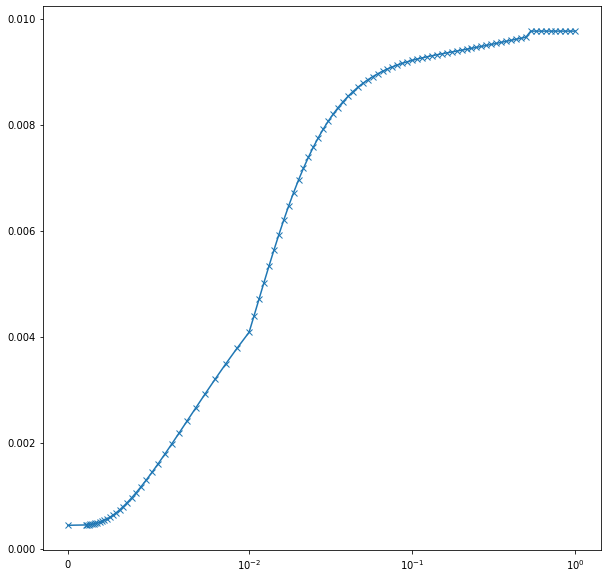

In [6]:
import matplotlib.pyplot as plt

mu_arr = Enz_arr * mu_max

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(u_arr, mu_arr, '-x', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

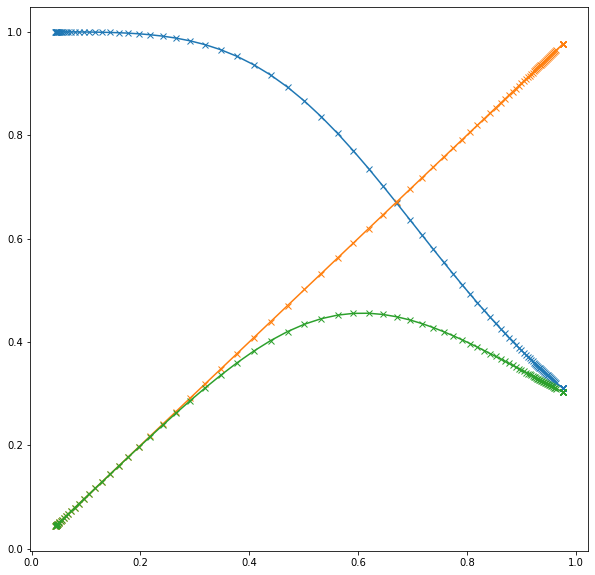

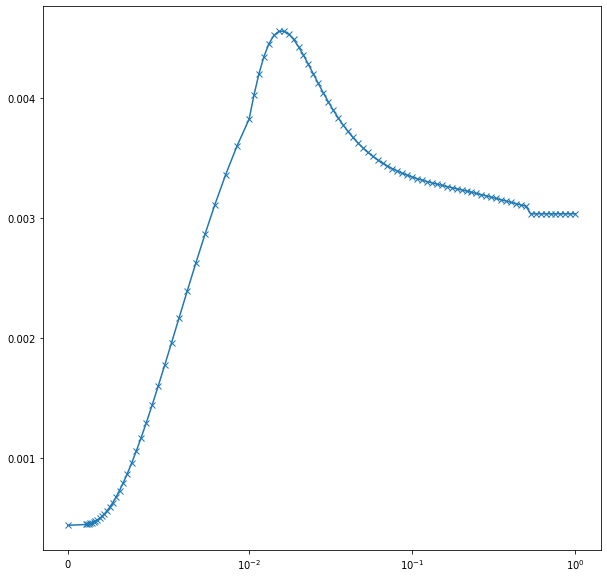

In [7]:
import matplotlib.pyplot as plt

Ki = 0.8
n=4


Kin_arr = Ki**n / (Ki**n + Enz_arr**n)
Enz_a2 = Enz_arr

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(Enz_arr, Kin_arr, '-x', label='mu')
ax.plot(Enz_arr, Enz_a2, '-x', label='mu')
ax.plot(Enz_arr, Enz_a2 * Kin_arr , '-x', label='mu')

mu_arr = Enz_arr * mu_max * Kin_arr

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(u_arr, mu_arr, '-x', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

my setpoint
[0.9794582  0.95319833]
0
The solver successfully reached the end of the integration interval.
True


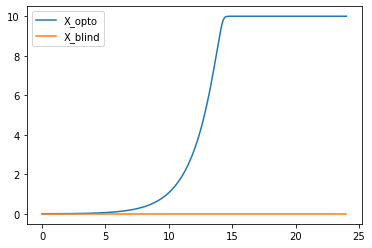

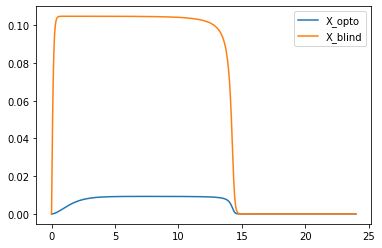

In [8]:
kdegR = 0.042116


optogrowth_p = kdegR, ktrans, kdegP, mu_max_opto, mu_max_blind, Ks, Y

# mRNA, Enz_opto, Enz_blind, S, Xopto, Xblind
x_init = [0, 0, 0, 20, 0.01, 0.0]

u = 1
period = 100 / 60
Imax = 1

setpoint = steady_mRNA_solve(u, period, Imax, x_guess=None)

print('my setpoint')
print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

def I_fun_macropulse(t_arr, macro_u, macro_period, u1, u2, period1, period2, Imax):
    I_arr = np.zeros(t_arr.size)
    for i, t in enumerate(t_arr):
        if t % macro_period < macro_u * macro_period:
            if t % period1 < u1 * period1:
                I_arr[i] = Imax
        else:
            if t % period2 < u2 * period2:
                I_arr[i] = Imax
    return I_arr


# def I_fun_base(t, u, period, Imax):
#     remainder = t - np.floor(t/period) * period
#     I_out = np.zeros(np.array(t).size)
#     I_out[remainder < u * period] = Imax
#     return I_out

if u > 0:
    max_step = u*period
else:
    max_step = period / 10

tspan = [0, 24*60]

sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )

print(sol.status)
print(sol.message)
print(sol.success)

mRNA, Enz_opto, Enz_blind, S, Xopto, Xblind = sol.y

mu_xopto = mu_max_opto * Enz_opto * S / (Ks + S)
mu_xblind = mu_max_blind * Enz_blind * S / (Ks + S)

plt.figure(facecolor='white')
plt.plot(sol.t/60, sol.y[4,:], label='X_opto')
plt.plot(sol.t/60, sol.y[5,:], label='X_blind')
plt.legend()

plt.figure(facecolor='white')
plt.plot(sol.t/60, mu_xopto, label='X_opto')
plt.plot(sol.t/60, mu_xblind, label='X_blind')
plt.legend()

# index1 = 100
# index2 = 130

# mume = (np.log(sol.y[4,:][index2]) - np.log(sol.y[4,:][index1])) / (sol.t[index2] - sol.t[index1])
# print('my mu is: ' + str(mume))

# plt.figure(facecolor='white')
# plt.plot(sol.t[index1:index2]/60, np.log(sol.y[4,:][index1:index2]), label='X_opto')
# # plt.plot(sol.t/60, sol.y[5,:], label='X_blind')
# plt.legend()

# plt.figure(facecolor='white')
# plt.plot(sol.t/60, sol.y[0,:], label='mRNA')
# plt.legend()

# plt.figure(facecolor='white')
# plt.plot(sol.t/60, sol.y[1,:], label='Enz_Opto')
# plt.plot(sol.t/60, sol.y[2,:], label='Enz_Blind')
# plt.legend()

# rangeme = 100
# plt.figure(facecolor='white')
# plt.plot(sol.t[:rangeme]/60, sol.y[1,:][:rangeme], label='Enz_Opto')
# plt.plot(sol.t[:rangeme]/60, sol.y[2,:][:rangeme], label='Enz_Blind')
# plt.legend()

# plt.figure(facecolor='white')
# plt.plot(sol.t/60, sol.y[3,:], label='S')
# plt.legend()



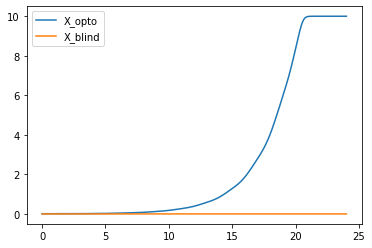

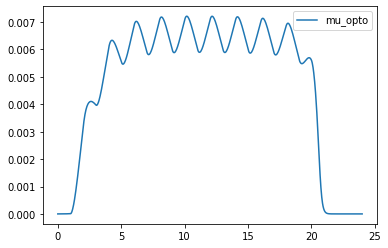

In [19]:
kdegR = 0.042116


optogrowth_p = kdegR, ktrans, kdegP, mu_max_opto, mu_max_blind, Ks, Y

# mRNA, Enz_opto, Enz_blind, S, Xopto, Xblind
x_init = [0, 0, 0, 20, 0.01, 0.0]

tspan_arr = np.linspace(0, 24, 25) * 60
u_arr = [0, 1] * int((tspan_arr.size-1)/2)

mRNA, Enz_opto, Enz_blind, S, Xopto, Xblind = [], [], [], [], [], []
t_arr = []

for i in range(len(u_arr)):
    tspan = [tspan_arr[i], tspan_arr[i+1]]
    u = u_arr[i]

    period = 100 / 60
    Imax = 1

    setpoint = steady_mRNA_solve(u, period, Imax, x_guess=None)

    # print('my setpoint')
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        # max_step=max_step,
                        )
    x_init = sol.y[:,-1]

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

    mRNA_x, Enz_opto_x, Enz_blind_x, S_x, Xopto_x, Xblind_x = sol.y
    mRNA.append(mRNA_x)
    Enz_opto.append(Enz_opto_x)
    Enz_blind.append(Enz_blind_x)
    S.append(S_x)
    Xopto.append(Xopto_x)
    Xblind.append(Xblind_x)
    t_arr.append(sol.t)

mRNA = np.hstack(mRNA)
Enz_opto = np.hstack(Enz_opto)
Enz_blind = np.hstack(Enz_blind)
S = np.hstack(S)
Xopto = np.hstack(Xopto)
Xblind = np.hstack(Xblind)
t_arr = np.hstack(t_arr)

mu_xopto = mu_max_opto * Enz_opto * S / (Ks + S)
mu_xblind = mu_max_blind * Enz_blind * S / (Ks + S)

plt.figure(facecolor='white')
plt.plot(t_arr/60, Xopto, label='X_opto')
plt.plot(t_arr/60, Xblind, label='X_blind')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_xopto, label='mu_opto')
# plt.plot(t_arr/60, mu_xblind, label='mu_blind')
plt.legend()

In [14]:
# u_arr * tspan_arr.size

[1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0]